# Support file

This file is meant to share some of the other methods I have tried during the completition of the assignment as the final result is a basic XGBoost

In [129]:
%matplotlib inline
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
import sklearn
import random
import time
import scipy
import datetime
import imblearn
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict, train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.model_selection  import ParameterGrid
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.linear_model import LogisticRegression
from mlens.ensemble import SuperLearner, BlendEnsemble, Subsemble, SequentialEnsemble
from sklearn.metrics import accuracy_score, mean_squared_error

seed = 983

## Import data and test data pre-processed

In [130]:
data=pd.read_csv('pre_processed_data.csv')
data = data.drop('Unnamed: 0', axis =1)

data_test=pd.read_csv('pre_processed_data_test.csv')
data_test = data_test.drop('Unnamed: 0', axis =1)

Finish the pre-processing:

Note that one the variables I use is com_prob. This variable captures the following.
A single client could have been more than once to the hospital and therfore having differnt diagnosis. The com_prob therfore it is nothing more than adding this probabilties. For example, if an individual went to the hospital before and according to his diagnosis, he had a death probabilty of 0.01, then if the current diagnosis assigns him a death probabily of 0.02, then the com_prob will capture this 0.03.

In [133]:
y = data['LOS']

numericals = ['HeartRate_Min','HeartRate_Max','HeartRate_Mean','SysBP_Min',
       'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
       'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min',
       'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean',
       'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max',
       'Glucose_Mean', 'age', 'com_prob', 'num_diag']

categoricals = ['ADMISSION_TYPE', 'FIRST_CAREUNIT', 'GENDER', 'ETHNICS',
                'RELIGION', 'INSURANCE','NIGHT', 'WEEKDAY', 'SEASON', 'DIAG', 'HOLIDAY']
#Notice DIAG and com_prob do not exist yet, they will be added in the following steps

variables = numericals + categoricals

# Categorical encoding so that the code runs
for n in [i for i in categoricals if i != 'DIAG']:
    dict = data.groupby(n)['HOSPITAL_EXPIRE_FLAG'].mean().to_dict()  
    data[n] = data[n].apply(lambda x: dict[x])
    data_test[n] = data_test[n].apply(lambda x: dict[x])
    

diag_mean_dict = data.groupby('ICD9_diagnosis')['HOSPITAL_EXPIRE_FLAG'].mean().to_dict()

def get_diag(x):
    if x in diag_mean_dict:
        return diag_mean_dict[x]
    else: 
        return data.HOSPITAL_EXPIRE_FLAG.mean()

data['DIAG'] = data['ICD9_diagnosis'].apply(get_diag)
data_test['DIAG'] = data_test['ICD9_diagnosis'].apply(get_diag)

data['com_prob'] = data.sort_values(['subject_id', 'ADMITTIME']).groupby('subject_id')['DIAG'].cumsum()

data_test['com_prob']=data_test.sort_values(['subject_id', 'ADMITTIME']).groupby('subject_id')['DIAG'].cumsum()

X_train = data[variables]
X_test = data_test[variables]

X_train.fillna(X_train.median(), inplace=True)
X_test.fillna(X_test.median(), inplace=True)

/opt/conda/lib/python3.8/site-packages/pandas/core/series.py:4529: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


## Dealing with Outliers and NAs

For dealing with outliers, I tried to delete all the rows with at one outlier in any column. I defined as an outlier a value falling below the 0.1 quantile and above the 0.9. I applied this code only to the numerical categoricals and then tried to run XBoost, ensables and random forest but none of them gave me a better result. I had 19437 rows, a big reduction. Almost 10% of the data.

I attach here how I got the data without the outliers (this code will not run because I don't want to change this data beacuse if you want to run this model, I would like it better with the original data).

In [140]:
df_out['num_diag'] = X_train.num_diag

<ipython-input-140-a4f96ba6e315>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_out['num_diag'] = X_train.num_diag


[Text(1, 0, 'HeartRate_Min'),
 Text(2, 0, 'HeartRate_Max'),
 Text(3, 0, 'HeartRate_Mean'),
 Text(4, 0, 'SysBP_Min'),
 Text(5, 0, 'SysBP_Max'),
 Text(6, 0, 'SysBP_Mean'),
 Text(7, 0, 'DiasBP_Min'),
 Text(8, 0, 'DiasBP_Max'),
 Text(9, 0, 'DiasBP_Mean'),
 Text(10, 0, 'MeanBP_Min'),
 Text(11, 0, 'MeanBP_Max'),
 Text(12, 0, 'MeanBP_Mean'),
 Text(13, 0, 'RespRate_Min'),
 Text(14, 0, 'RespRate_Max'),
 Text(15, 0, 'RespRate_Mean'),
 Text(16, 0, 'TempC_Min'),
 Text(17, 0, 'TempC_Max'),
 Text(18, 0, 'TempC_Mean'),
 Text(19, 0, 'SpO2_Min'),
 Text(20, 0, 'SpO2_Max'),
 Text(21, 0, 'SpO2_Mean'),
 Text(22, 0, 'Glucose_Min'),
 Text(23, 0, 'Glucose_Max'),
 Text(24, 0, 'Glucose_Mean'),
 Text(25, 0, 'age'),
 Text(26, 0, 'com_prob'),
 Text(27, 0, 'num_diag')]

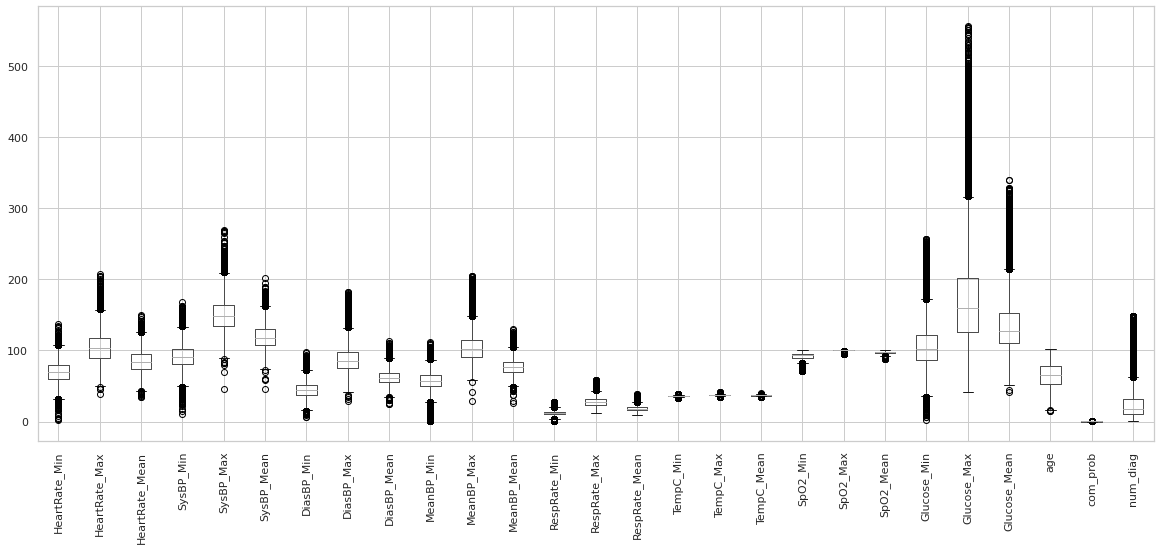

In [141]:
boxplot = df_out.boxplot(column = numericals, figsize=(20,8))
boxplot.set_xticklabels(boxplot.get_xticklabels(), rotation=90)

In [142]:
#Count how many there are
Q1 = data[numericals].quantile(0.1)
Q3 = data[numericals].quantile(0.9)
IQR = Q3 - Q1

df_out = data[~((data[numericals] < (Q1 - 1.5 * IQR)) |(data[numericals] > (Q3 + 1.5 * IQR))).any(axis=1)]

#### NAs

For NA values, I tried removing them, substitute them by median and mean and I also tried to do it by KNN but it did not have a good accuracy.

Finally, after doing several attemps, I relized the one that performed better was the median.

The KNN code won't run 

In [143]:
X_train.fillna(X_train.mean(), inplace=True)
X_test.fillna(X_test.mean(), inplace=True)

/opt/conda/lib/python3.8/site-packages/pandas/core/series.py:4529: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [144]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=100, weights='distance')

numericals_with_na  = ['Glucose_Mean', 'Glucose_Max', 'Glucose_Min', 'HeartRate_Min','HeartRate_Max','HeartRate_Mean',
         'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min', 'RespRate_Max', 'RespRate_Mean',
         'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
         'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean']

columns = ['Glucose_Mean', 'Glucose_Max', 'Glucose_Min', 'HeartRate_Min','HeartRate_Max','HeartRate_Mean',
         'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min', 'RespRate_Max', 'RespRate_Mean',
         'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
         'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean']

#variables with NA's in order (first the ones with fewer NA's)
for n in numericals_with_na:

    x_trainNN = X_train[X_train[n].notnull()].drop(columns, axis =1)
    y_trainNN = X_train[X_train[n].notnull()][n]
    x_train_missing = X_train[X_train[n].isnull()].drop(columns, axis =1)
    y_train_missing = X_train[X_train[n].isnull()][n]

    x_test_missing = X_test[X_test[n].isnull()].drop(columns, axis =1)
    y_test_missing = X_test[X_test[n].isnull()][n]

    # scale before running model
    from sklearn import preprocessing
    scaler = preprocessing.StandardScaler(with_mean=True, with_std=True).fit(x_trainNN)
    x_trainNN= scaler.transform(x_trainNN)
    x_train_missing=scaler.transform(x_train_missing)
    x_test_missing=scaler.transform(x_test_missing)

    #Train the KNN
    knn.fit(x_trainNN, y_trainNN)

    #Predict the missing values for both X_train and X_test.
    predicted_train = knn.predict(x_train_missing)
    predicted_test = knn.predict(x_test_missing)
    
    #Insert the predictions into the data sets
    X_train.loc[X_train[n].isnull(), n] = predicted_train
    X_test.loc[X_test[n].isnull(), n] = predicted_test
    
    columns.remove(n)

ValueError: Found array with 0 sample(s) (shape=(0, 14)) while a minimum of 1 is required by StandardScaler.

### Variable corraltions


The varaibles that are correlated are the numeric ones, and in order to decrease the dimensionality I will remove the min and the max, being the mean the one that works better for predicting purposes. 

For the non numeric, we can see there is a corralrion of 0.4 with first care unit and andmission type, I tried dropping Admission type as for XGBoost it had lower prediction ablility but the result did not improve.
There is also high correlation with insurance and age but after removing insurance (having less explanatory pwoer according to the oimportance of features in XGBoost) the reuslt did not imporove in this case either.
There is also high correaltion with com_prob and diagnosis, which is obvius as commulative probability is the the commulative sum of diagnosis and for the ones that only visited one time is the same, also for the first visit but after dropping com_prob, the performace did not improve.
And finally with season and holiday which none of the end up being important.

In the final model, this correlatins in the non numeric one are irrelevant as we just end up using First care unit, admision type and diagnosis. I tried running the model droping admision type and using first cre unit and visceversa but the result was not good, they act better together.

Finally I tried to run the model (XGBoost) with just the mean in the numerics and these three categorical varibales, reducing dimensionality to 11 but the model did not predict better.

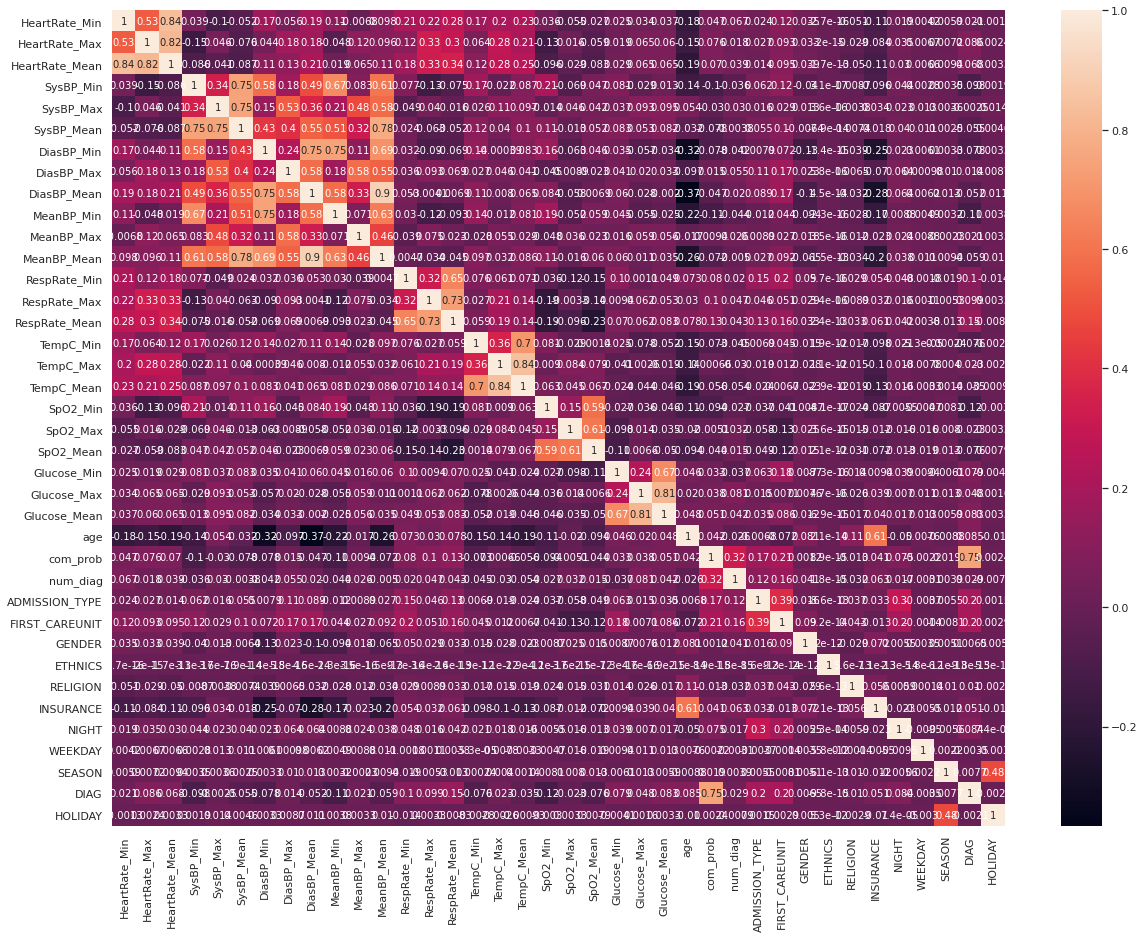

In [145]:
plt.subplots(figsize=(20,15))

correlation_mat = X_train.corr()

sns.heatmap(correlation_mat, annot = True)

plt.show()

### Ada Boost

In [146]:
model = AdaBoostRegressor()

grid_values = {'n_estimators': [100, 200],
                'random_state': [seed],
                'learning_rate': [0.1]
}


grid_ab_acc = GridSearchCV(model, param_grid = grid_values, scoring = 'neg_mean_squared_error', cv=5, n_jobs=3)

grid_ab_acc.fit(X_train, y)

y_pred_acc = grid_ab_acc.predict(X_test)

print("MSE::{}".format(grid_ab_acc.best_score_))
print("Best Hyperparameters::\n{}".format(grid_ab_acc.best_params_))

MSE::-38.32723717074704
Best Hyperparameters::
{'learning_rate': 0.1, 'n_estimators': 100, 'random_state': 983}


### Decision tree

In [147]:
model = DecisionTreeRegressor(min_samples_split=5, max_features= 'auto')

grid_values = {'criterion': ['mse'],
              'splitter': ['best', 'random'],
              'max_depth': [3],
              'min_samples_leaf': [20,50],
              'max_leaf_nodes': [50,100]
              }


grid_dt_acc = GridSearchCV(model, param_grid = grid_values, scoring = 'neg_mean_squared_error', cv=5, n_jobs=3)

grid_dt_acc.fit(X_train,y)

y_pred_acc = grid_dt_acc.predict(X_test)

print("MSE::{}".format(grid_dt_acc.best_score_))
print("Best Hyperparameters::\n{}".format(grid_dt_acc.best_params_))

MSE::-24.756065327377698
Best Hyperparameters::
{'criterion': 'mse', 'max_depth': 3, 'max_leaf_nodes': 50, 'min_samples_leaf': 50, 'splitter': 'best'}


### Simple Random Forest

In [148]:
%%time

model = RandomForestRegressor(random_state=38)


grid_values = {'n_estimators': [150],
            'max_features': ['auto', 'log2'],
            'max_depth' : [3],
            'criterion' :['mse']
}

grid_rf_acc = GridSearchCV(model, param_grid = grid_values, scoring = 'neg_mean_squared_error', cv=5, n_jobs=3)

grid_rf_acc.fit(X_train,y)

y_pred_acc = grid_rf_acc.predict(X_test)

print("Best MSE::\n{}".format(grid_rf_acc.best_score_))
print("Best Hyperparameters::\n{}".format(grid_rf_acc.best_params_))

Best MSE::
-24.58370239087808
Best Hyperparameters::
{'criterion': 'mse', 'max_depth': 3, 'max_features': 'auto', 'n_estimators': 150}
CPU times: user 7.77 s, sys: 0 ns, total: 7.77 s
Wall time: 20.4 s


### XGBoost with selection variable from Random Forest

In [149]:
# Run Random forest to get the importance of the features and then proceed to the selection

model = RandomForestRegressor(random_state=38)


grid_values = {'n_estimators': [150],
            'max_features': ['auto', 'log2'],
            'max_depth' : [3],
            'criterion' :['mse']
}

grid_rf_acc = GridSearchCV(model, param_grid = grid_values, scoring = 'neg_mean_squared_error', cv=5, n_jobs=3)

grid_rf_acc.fit(X_train,y)

y_pred_acc = grid_rf_acc.predict(X_test)

print("Best MSE::\n{}".format(grid_rf_acc.best_score_))
print("Best Hyperparameters::\n{}".format(grid_rf_acc.best_params_))

Best MSE::
-24.58370239087808
Best Hyperparameters::
{'criterion': 'mse', 'max_depth': 3, 'max_features': 'auto', 'n_estimators': 150}


In [150]:
importances = grid_rf_acc.best_estimator_.feature_importances_
important_features = pd.Series(data=importances/importances.max() ,index=X_train.columns).sort_values(ascending=False)
important_features

num_diag          1.000000
TempC_Max         0.407644
DIAG              0.201058
SysBP_Min         0.078691
HeartRate_Max     0.057475
Glucose_Mean      0.049148
TempC_Mean        0.034302
RespRate_Mean     0.022601
RespRate_Max      0.017225
HeartRate_Mean    0.011602
Glucose_Max       0.008105
com_prob          0.007224
HeartRate_Min     0.006761
TempC_Min         0.005181
DiasBP_Min        0.004473
SpO2_Mean         0.002978
age               0.002307
MeanBP_Max        0.001211
MeanBP_Mean       0.001064
WEEKDAY           0.000955
SpO2_Min          0.000617
SpO2_Max          0.000000
DiasBP_Max        0.000000
SEASON            0.000000
NIGHT             0.000000
INSURANCE         0.000000
SysBP_Max         0.000000
SysBP_Mean        0.000000
RELIGION          0.000000
DiasBP_Mean       0.000000
Glucose_Min       0.000000
MeanBP_Min        0.000000
ETHNICS           0.000000
GENDER            0.000000
RespRate_Min      0.000000
FIRST_CAREUNIT    0.000000
ADMISSION_TYPE    0.000000
H

In [151]:
# Selectin the variables over 0.01

columns = important_features.index.tolist()[0:33]

In [152]:
# Run XGBoost to get the prediction


model = XGBRegressor()

grid_values = {
    'n_estimators' : [200,150],
    'learning_rate': [0.1,0.2], #so called `eta` value
    'max_depth': [3],
    'random_state' : [seed],
    'sampling_method': ['uniform', 'gradient_based']
}


grid_xgb_acc = GridSearchCV(model, param_grid = grid_values, cv=5, scoring='neg_mean_squared_error')

grid_xgb_acc.fit(X_train, y)

y_pred_acc = grid_xgb_acc.predict(X_test)

print("MSE::{}".format(grid_xgb_acc.best_score_))
print("Best Hyperparameters::\n{}".format(grid_xgb_acc.best_params_))

MSE::-22.74404293221945
Best Hyperparameters::
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'random_state': 983, 'sampling_method': 'uniform'}


## Ensambles

In order to validate the preformance of the ensambles I will create a test and train split to be able to evaluate its performance. Otherwise I would be testing its perfomance on a data that has been used to estimate the parameters, therfore being over optimistic.

In [153]:
# Train test split
from sklearn.model_selection import train_test_split

col = X_train.columns

X_train, X_test, y_train, y_test = train_test_split(np.array(X_train),y,test_size=0.7, shuffle=True,random_state=seed)

X_train = pd.DataFrame(X_train)
X_train.columns = col
X_test = pd.DataFrame(X_test)
X_test.columns = col
y_train = pd.Series(y_train)
y_train = pd.Series(y_train)

Running random forest with the new data

In [154]:

model = RandomForestRegressor(random_state=38)


grid_values = {'n_estimators': [100,200,300],
            'max_features': ['auto', 'log2'],
            'max_depth' : [3],
            'criterion' :['mse'],
               'random_state': [seed]
}

grid_rf_acc = GridSearchCV(model, param_grid = grid_values, scoring = 'neg_mean_squared_error', cv=5, n_jobs=3)

grid_rf_acc.fit(X_train,y_train)

y_pred_acc = grid_rf_acc.predict(X_test)

print("Best negative MSE::\n{}".format(grid_rf_acc.best_score_))
print("Best Hyperparameters::\n{}".format(grid_rf_acc.best_params_))

Best negative MSE::
-24.39830610247056
Best Hyperparameters::
{'criterion': 'mse', 'max_depth': 3, 'max_features': 'auto', 'n_estimators': 300, 'random_state': 983}


Running random forest with the new data

In [155]:


model = XGBRegressor()

grid_values = {
    'n_estimators' : [50,60,70,80],
    'learning_rate': [0.1,0.125,0.15], #so called `eta` value
    'max_depth': [3],
    'random_state' : [seed],
    'sampling_method': ['uniform', 'gradient_based']
}


grid_xgb_acc = GridSearchCV(model, param_grid = grid_values, cv=5, scoring='neg_mean_squared_error')

grid_xgb_acc.fit(X_train, y_train)

y_pred_acc = grid_xgb_acc.predict(X_test)

print("Best negative MSE::{}".format(grid_xgb_acc.best_score_))
print("Best Hyperparameters::\n{}".format(grid_xgb_acc.best_params_))

Best negative MSE::-23.2670343653351
Best Hyperparameters::
{'learning_rate': 0.15, 'max_depth': 3, 'n_estimators': 80, 'random_state': 983, 'sampling_method': 'uniform'}


In [156]:
# Main code

def get_models():
    #Generate a library of simple models with the hyperparmeters of the best models run above
    xgb = XGBRegressor(learning_rate = 0.125, max_depth = 3, n_estimators =70, 
                       random_state = 54, sampling_method = 'uniform')
    rf = RandomForestRegressor(random_state = 54, criterion = 'mse', max_depth = 3, 
                               max_features = 'log2', n_estimators = 200)

    models = {'XGBoost': xgb,
              'random_forest': rf
             }

    return models


def train_predict(model_list,X_train=X_train,y_train=y_train,X_test=X_test,y_test=y_test):
    #Fit models in list on training set and return preds
    P = np.zeros((y_test.shape[0], len(model_list))) #rows of the y (predictions) and columns of the models we will test
    P = pd.DataFrame(P) #dataframe wehre we will store the predictions

    cols = list()
    for i, (name, m) in enumerate(models.items()): #i is the index of the model in model.items and name and m the model (look at dic)
        print("%s..." % name, end=" ", flush=False)
        m.fit(X_train, y_train) #xtrian 
        P.iloc[:, i] = pd.DataFrame(m.predict(X_test)).iloc[:, 0] #store the predictions in the corresponding clumn
        cols.append(name) 
        print("done")

    P.columns = cols
    print("Done.\n")
    return P


def score_models(P, y):
    # Score model in test set
    print("Scoring models.")
    scores=[]
    for m in P.columns:
        score = mean_squared_error(y, P.loc[:, m]) #score roc auc for the models and stor the score (y is the ytest)
        scores.append(score)
        print("%-26s: %.3f" % (m, score))
    return P.columns,scores


In [157]:
models = get_models()
P = train_predict(models,X_train,y_train,X_test,y_test)
my_models,my_scores= score_models(P, y_test)

XGBoost... done
random_forest... done
Done.

Scoring models.
XGBoost                   : 23.536
random_forest             : 25.007


In [158]:
# Save results
results=[(model,score) for model,score in zip(my_models,my_scores)]
results

[('XGBoost', 23.536124569732717), ('random_forest', 25.007288384535855)]

In [159]:
# Simple average

AvgPred=pd.DataFrame(P.mean(axis=1),columns=['Avg']) #average among all the collumns (en each row)
my_models3,my_scores3= score_models(AvgPred, y_test)
# Save results
results=results+[(model,score) for model,score in zip(my_models3,my_scores3)]

Scoring models.
Avg                       : 23.846


#### Bagging

Now lets do a more complex one and see it it operates better than the others:

I will try combinations of Random Forest and XGBoost with bootstraps

In [160]:
def test_classification(X_train,X_test,y_train,SEED):
    # Check classification for various parameter settings.

    grid = ParameterGrid({"max_samples": [0.8, 1.0],
                          "bootstrap": [True, False],
                          "bootstrap_features": [True, False]})
    
    results=[]
    
    xgb = XGBRegressor(learning_rate = 0.125, max_depth = 3, n_estimators =165, 
                       random_state = 54, sampling_method = 'uniform')
    rf = RandomForestRegressor(random_state = 38, criterion = 'mse', max_depth = 3, 
                                max_features = 'log2', n_estimators = 150)
    
    for base_estimator in [xgb, rf]:
        print("Computing "+ type(base_estimator).__name__)
        for params in grid:
            out=BaggingRegressor(base_estimator=base_estimator,n_estimators=5,
                              random_state=seed,
                              **params).fit(X_train, y_train).predict(X_test)
            results.append((type(base_estimator).__name__,params,out))
    return results

out=test_classification(X_train,X_test,y_train,seed)

Computing XGBRegressor
Computing RandomForestRegressor


In [161]:
# Compute Probabilities per model
P5=pd.DataFrame()
for i in range(len(out)):
    this_case=[x for x in out[i][2]]
    this_df=pd.DataFrame(this_case, columns=[out[i][0]+str(out[i][1])])
    P5=pd.concat([P5, this_df], axis=1)
P5

,"XGBRegressor{'bootstrap': True, 'bootstrap_features': True, 'max_samples': 0.8}","XGBRegressor{'bootstrap': True, 'bootstrap_features': True, 'max_samples': 1.0}","XGBRegressor{'bootstrap': True, 'bootstrap_features': False, 'max_samples': 0.8}","XGBRegressor{'bootstrap': True, 'bootstrap_features': False, 'max_samples': 1.0}","XGBRegressor{'bootstrap': False, 'bootstrap_features': True, 'max_samples': 0.8}","XGBRegressor{'bootstrap': False, 'bootstrap_features': True, 'max_samples': 1.0}","XGBRegressor{'bootstrap': False, 'bootstrap_features': False, 'max_samples': 0.8}","XGBRegressor{'bootstrap': False, 'bootstrap_features': False, 'max_samples': 1.0}","RandomForestRegressor{'bootstrap': True, 'bootstrap_features': True, 'max_samples': 0.8}","RandomForestRegressor{'bootstrap': True, 'bootstrap_features': True, 'max_samples': 1.0}","RandomForestRegressor{'bootstrap': True, 'bootstrap_features': False, 'max_samples': 0.8}","RandomForestRegressor{'bootstrap': True, 'bootstrap_features': False, 'max_samples': 1.0}","RandomForestRegressor{'bootstrap': False, 'bootstrap_features': True, 'max_samples': 0.8}","RandomForestRegressor{'bootstrap': False, 'bootstrap_features': True, 'max_samples': 1.0}","RandomForestRegressor{'bootstrap': False, 'bootstrap_features': False, 'max_samples': 0.8}","RandomForestRegressor{'bootstrap': False, 'bootstrap_features': False, 'max_samples': 1.0}"
0,1.726268,1.681740,2.031475,1.753667,2.197539,2.114805,2.096900,2.208482,3.297659,3.234952,3.451752,3.370698,3.276661,3.294815,3.331557,3.355345
1,1.773397,2.141618,1.183647,1.261963,2.009523,1.871312,0.914651,1.122280,3.810401,3.960038,3.529069,3.504048,3.761353,3.744740,3.505602,3.511754
2,3.790020,3.484726,3.555160,3.603308,4.038754,4.043425,4.149899,4.122796,3.260963,3.295829,3.553417,3.564905,3.329800,3.337470,3.630182,3.669283
3,4.174405,3.997291,3.996753,3.745406,4.302697,4.365808,3.927148,3.844932,3.671951,3.660283,3.508175,3.493877,3.746925,3.776989,3.533601,3.604092
4,2.918007,2.988039,3.043385,2.982121,3.172384,3.186477,2.951590,2.961030,3.358227,3.354078,3.211495,3.238803,3.385732,3.317130,3.369297,3.292106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14615,2.253461,2.344386,1.223862,2.702741,2.965866,2.435041,3.027369,3.392258,3.058421,3.022381,2.845099,2.854425,3.033158,2.987060,2.895599,2.812595
14616,5.115481,4.697803,5.571650,5.906961,4.950567,4.849813,5.105917,5.411863,3.901972,3.844431,4.086285,4.064881,3.996250,3.955453,4.149457,4.145911
14617,4.938624,5.179190,5.946698,6.157128,5.155415,5.447251,5.699862,6.665941,4.275993,4.223542,4.250165,4.253445,4.242656,4.304688,4.270924,4.365978
14618,4.030850,4.384766,4.212565,4.465639,4.766045,4.350896,4.498534,4.751042,3.898841,3.842705,4.046037,4.062776,3.892755,3.774414,4.096280,3.994102


In [162]:
my_models5,my_scores5= score_models(P5, y_test)

Scoring models.
XGBRegressor{'bootstrap': True, 'bootstrap_features': True, 'max_samples': 0.8}: 23.579
XGBRegressor{'bootstrap': True, 'bootstrap_features': True, 'max_samples': 1.0}: 23.598
XGBRegressor{'bootstrap': True, 'bootstrap_features': False, 'max_samples': 0.8}: 23.323
XGBRegressor{'bootstrap': True, 'bootstrap_features': False, 'max_samples': 1.0}: 23.342
XGBRegressor{'bootstrap': False, 'bootstrap_features': True, 'max_samples': 0.8}: 23.605
XGBRegressor{'bootstrap': False, 'bootstrap_features': True, 'max_samples': 1.0}: 23.523
XGBRegressor{'bootstrap': False, 'bootstrap_features': False, 'max_samples': 0.8}: 23.405
XGBRegressor{'bootstrap': False, 'bootstrap_features': False, 'max_samples': 1.0}: 23.578
RandomForestRegressor{'bootstrap': True, 'bootstrap_features': True, 'max_samples': 0.8}: 25.233
RandomForestRegressor{'bootstrap': True, 'bootstrap_features': True, 'max_samples': 1.0}: 25.241
RandomForestRegressor{'bootstrap': True, 'bootstrap_features': False, 'max_sam

In [163]:
results=results+[(model,score) for model,score in zip(my_models5,my_scores5)]

#### Stacking
Lets now try the stacking ensable method. Stacking combines differnt models and fits them on the same data frame, in stead of samples on the training data set and will try to combine the models in the best possible way.
In order to do it I will define a metalearner and applying it to differnt models, both XGBoost and Random Forest, I have used differnt types: 
   + Random Forest Regressor
   + XGBoost
   + Extra Trees
   
The best metalearner has been so far XGBoost so it is the one I put here.

In [164]:
# Define the meta learner
meta_learner = XGBRegressor(n_estimators=100,
                                    max_depth = 3,
                                    random_state=seed)


In [165]:
## Define the stacking of our ensamble

# Instantiate the ensemble with 5 folds (stacking meta-learner)
sl = SuperLearner(folds=5,
                random_state = seed,
                verbose=2,
                backend="threading",
                n_jobs=3
)

# Add the base learners and the meta learner
sl.add(list(models.values()))
sl.add_meta(meta_learner)

# Train the ensemble
sl.fit(X_train, y_train)

# Predict the test set
p_sl = sl.predict(X_test)
scoreStackXtres=mean_squared_error(y_test, p_sl)
print("\nSuper Learner MSE score: %.3f" % scoreStackXtres)


Fitting 2 layers
Processing layer-1             done | 00:00:03
Processing layer-2             done | 00:00:00
Fit complete                        | 00:00:04

Predicting 2 layers
Processing layer-1             done | 00:00:00
Processing layer-2             done | 00:00:00
Predict complete                    | 00:00:00

Super Learner MSE score: 25.478


In [166]:
# Finally lets add the result into the previous results

results=results+[('Stacking',scoreStackXtres)]
results

[('XGBoost', 23.536124569732717),
 ('random_forest', 25.007288384535855),
 ('Avg', 23.84563736832552),
 ("XGBRegressor{'bootstrap': True, 'bootstrap_features': True, 'max_samples': 0.8}",
  23.57869991436588),
 ("XGBRegressor{'bootstrap': True, 'bootstrap_features': True, 'max_samples': 1.0}",
  23.598227868065585),
 ("XGBRegressor{'bootstrap': True, 'bootstrap_features': False, 'max_samples': 0.8}",
  23.323233383848873),
 ("XGBRegressor{'bootstrap': True, 'bootstrap_features': False, 'max_samples': 1.0}",
  23.34198428956588),
 ("XGBRegressor{'bootstrap': False, 'bootstrap_features': True, 'max_samples': 0.8}",
  23.604610226092774),
 ("XGBRegressor{'bootstrap': False, 'bootstrap_features': True, 'max_samples': 1.0}",
  23.52341812220132),
 ("XGBRegressor{'bootstrap': False, 'bootstrap_features': False, 'max_samples': 0.8}",
  23.405242685629812),
 ("XGBRegressor{'bootstrap': False, 'bootstrap_features': False, 'max_samples': 1.0}",
  23.57763480121327),
 ("RandomForestRegressor{'boo

#### Feature propagation

In [167]:
# Select features to propagate
to_propagate=['DIAG','TempC_Max','SysBP_Min', 'HeartRate_Max'] # varibales with importance higher than 0.15
pointer= [i for i,x in enumerate(X_train.columns) if x in to_propagate]
X_train.columns[pointer]

Index(['HeartRate_Max', 'SysBP_Min', 'TempC_Max', 'DIAG'], dtype='object')

In [168]:
X_arr = X_train.to_numpy()
y_arr = y_train.to_numpy()
X_test_arr = X_test.to_numpy()

In [169]:
## Define the stacking of our ensamble

# Instantiate the ensemble with 5 folds (stacking meta-learner)
sl = SuperLearner(folds=5,
                random_state = seed,
                verbose=2,
                backend="threading",
                n_jobs=3
)

# Add the base learners and the meta learner
sl.add(list(models.values()), propagate_features=pointer)
sl.add_meta(meta_learner)

# Train the ensemble
sl.fit(X_arr, y_arr)

# Predict the test set

p_sl = sl.predict(X_test_arr)
scoreStackXtres=mean_squared_error(y_test, p_sl)
print("\nSuper Learner MSE score: %.3f" % scoreStackXtres)


Fitting 2 layers
Processing layer-1             done | 00:00:04
Processing layer-2             done | 00:00:00
Fit complete                        | 00:00:04

Predicting 2 layers
Processing layer-1             done | 00:00:00
Processing layer-2             done | 00:00:00
Predict complete                    | 00:00:00

Super Learner MSE score: 24.907


In [170]:
# Finally lets add the result into the previous results

results=results+[('Feature Propagation',scoreStackXtres)]
results

[('XGBoost', 23.536124569732717),
 ('random_forest', 25.007288384535855),
 ('Avg', 23.84563736832552),
 ("XGBRegressor{'bootstrap': True, 'bootstrap_features': True, 'max_samples': 0.8}",
  23.57869991436588),
 ("XGBRegressor{'bootstrap': True, 'bootstrap_features': True, 'max_samples': 1.0}",
  23.598227868065585),
 ("XGBRegressor{'bootstrap': True, 'bootstrap_features': False, 'max_samples': 0.8}",
  23.323233383848873),
 ("XGBRegressor{'bootstrap': True, 'bootstrap_features': False, 'max_samples': 1.0}",
  23.34198428956588),
 ("XGBRegressor{'bootstrap': False, 'bootstrap_features': True, 'max_samples': 0.8}",
  23.604610226092774),
 ("XGBRegressor{'bootstrap': False, 'bootstrap_features': True, 'max_samples': 1.0}",
  23.52341812220132),
 ("XGBRegressor{'bootstrap': False, 'bootstrap_features': False, 'max_samples': 0.8}",
  23.405242685629812),
 ("XGBRegressor{'bootstrap': False, 'bootstrap_features': False, 'max_samples': 1.0}",
  23.57763480121327),
 ("RandomForestRegressor{'boo

In [171]:
results_df=pd.DataFrame(results)
results_df.columns=['Method','MSE']
results_df= results_df.sort_values(by='MSE', ascending=True)
results_df.head()

,Method,MSE
5,"XGBRegressor{'bootstrap': True, 'bootstrap_fea...",23.323233
6,"XGBRegressor{'bootstrap': True, 'bootstrap_fea...",23.341984
9,"XGBRegressor{'bootstrap': False, 'bootstrap_fe...",23.405243
8,"XGBRegressor{'bootstrap': False, 'bootstrap_fe...",23.523418
0,XGBoost,23.536125


(23.0, 26.0)

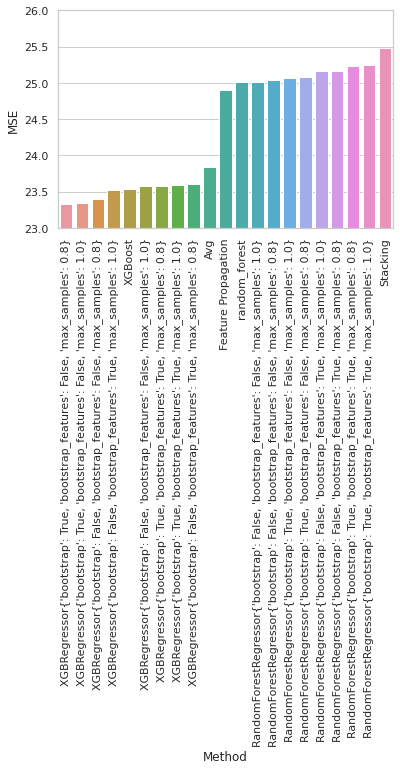

In [172]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
ax = sns.barplot(x="Method", y="MSE", data=results_df)
ax= ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.ylim(23, 26)

By plotting this plot I could see that the one with higher out of sample accuracy was XGBoost with boostraps in the features, and then the XGBoost. 

After having pushed all to Kaggle, the one with highest accuracy was XGBoost. Here I attach the results I got for the best ensables mentioned above:
   + XGBoost = 4.41
   + XGBoost Stacking = 4.451
   + XBoost Bagging features boostrap = 4.457